##### _Copyright 2021 Google LLC_

_Licensed under the Apache License, Version 2.0 (the "License")_


In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Retrain SSDLite Mobiledet object detector for the Coral Edge TPU (TF1)


This tutorial shows you how to perform transfer-learning with a pre-trained SSDLite MobileDet model so it can detect cats and dogs. We'll use TensorFlow 1.15 for training, and then use quantization-aware training and the Edge TPU Compiler to make the model compatible with the [Coral Edge TPU](https://coral.ai/products/).

Here's an example of the training results:

<img src="https://storage.googleapis.com/site_and_emails_static_assets/Images/detection-cats-and-dogs.jpg" />

**Beware:** This Colab takes about 3 hours to finish and that's only because we dialed-down a couple training parameters so it doesn't take even longer (which would cause your Colab instance to time-out and stop your training) or run out of memory. Although the results are still good, you'll get even better results (a more accurate model) if you [connect this notebook to a local runtime](https://research.google.com/colaboratory/local-runtimes.html), or upgrade to [Colab Pro](https://colab.research.google.com/signup) (which provides faster GPUs, longer run-times, and more memory), and then increase the number of training steps and the batch size.


<a href="https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_ssdlite_mobiledet_qat_tf1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"></a>
&nbsp;&nbsp;&nbsp;&nbsp;
<a href="https://github.com/google-coral/tutorials/blob/master/retrain_ssdlite_mobiledet_qat_tf1.ipynb" target="_parent"><img src="https://img.shields.io/static/v1?logo=GitHub&label=&color=333333&style=flat&message=View%20on%20GitHub" alt="View in GitHub"></a>


To start running all the code in this tutorial, select **Runtime > Run all** in the Colab toolbar.


## Install the code dependencies


In [2]:
! pip install -U numpy==1.18.5
! pip install -U pycocotools==2.0.1

  Using cached numpy-1.18.5-cp37-cp37m-manylinux1_x86_64.whl (20.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.0
    Uninstalling numpy-1.19.0:
      Successfully uninstalled numpy-1.19.0
You should consider upgrading via the '/home/chun/.virtualenvs/tf1_15/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/chun/.virtualenvs/tf1_15/bin/python -m pip install --upgrade pip' command.


Make sure you're using TensorFlow 1.15:


In [2]:
import os

os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"


In [1]:
import tensorflow as tf

# assert tf.__version__.startswith("1")


2022-11-06 19:44:41.255693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 19:44:41.334939: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-06 19:44:41.354133: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-06 19:44:41.817139: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Then we need to build the [TF1 Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1.md):


In [6]:
! pip install tf_slim
! git clone https://github.com/tensorflow/models.git objects_on_road_processor/tensorflow/models

Cloning into 'objects_on_road_processor/tensorflow/models'...
remote: Enumerating objects: 78535, done.
remote: Counting objects: 100% (338/338), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 78535 (delta 164), reused 288 (delta 143), pack-reused 78197
Receiving objects: 100% (78535/78535), 593.72 MiB | 10.84 MiB/s, done.
Resolving deltas: 100% (55787/55787), done.


In [ ]:
# export PYTHONPATH="objects_on_road_processor/tensorflow/models/research/:objects_on_road_processor/tensorflow/models/research/slim/:objects_on_road_processor/tensorflow/models/research/object_detection/utils/:objects_on_road_processor/tensorflow/models/research/object_detection:{$PYTHONPATH}"


In [2]:
models_dir = "objects_on_road_processor/tensorflow/models"
os.environ["PYTHONPATH"] = ""
os.environ["PYTHONPATH"] += f"{models_dir}/research/"
os.environ["PYTHONPATH"] += f":{models_dir}/research/slim/"
os.environ["PYTHONPATH"] += f":{models_dir}/research/object_detection/utils/"
os.environ["PYTHONPATH"] += f":{models_dir}/research/object_detection"


In [11]:
os.environ["PYTHONPATH"]


'objects_on_road_processor/tensorflow/models/research/:objects_on_road_processor/tensorflow/models/research/slim/:objects_on_road_processor/tensorflow/models/research/object_detection/utils/:objects_on_road_processor/tensorflow/models/research/object_detection'

In [9]:
! apt-get install protobuf-compiler

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [19]:
%cd objects_on_road_processor/tensorflow/models/research
# Compile all the protobuf dependencies
! protoc object_detection/protos/*.proto --python_out=.
# Set up and install the object detection API
! cp object_detection/packages/tf1/setup.py .
! python -m pip install .
# Run a test to make sure setup is correct
# ! python object_detection/builders/model_builder_test.py

[Errno 2] No such file or directory: 'objects_on_road_processor/tensorflow/models/research'
/home/chun/workspaces/tpu/DeepPiCar/objects_on_road_processor/tensorflow/models/research
Processing /home/chun/workspaces/tpu/DeepPiCar/objects_on_road_processor/tensorflow/models/research
  Preparing metadata (setup.py) ... done
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1696688 sha256=13c0819b3aa60f189e9602a28cb7aa4d7935f367ae7129f7cad0523d675cd612
  Stored in directory: /tmp/pip-ephem-wheel-cache-a1q9seab/wheels/d6/8f/b7/ef138e3b062d0946a5fa1d5abe3565ad078c332e845a386149
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


## Prepare the training dataset


Now let's get the training dataset. We're using is the [Oxford-IIIT Pets Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), which includes 37 different classes of dog and cat breeds. But for this tutorial, we'll use just 2 classes for training: Abyssinian cats and American Bulldogs.


In [ ]:
# Download the dataset files
%mkdir /content/dataset
%cd /content/dataset
! wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
! wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
! tar zxf images.tar.gz
! tar zxf annotations.tar.gz

In [ ]:
# Only picking Abyssinian Cat and the American Bulldog
# If you wish to train the model on all classes, simply skip this entire cell
! cp /content/dataset/annotations/list.txt /content/dataset/annotations/list_petsdataset.txt
! cp /content/dataset/annotations/trainval.txt /content/dataset/annotations/trainval_petsdataset.txt
! cp /content/dataset/annotations/test.txt /content/dataset/annotations/test_petsdataset.txt
! grep "Abyssinian" /content/dataset/annotations/list_petsdataset.txt >  /content/dataset/annotations/list.txt
! grep "american_bulldog" /content/dataset/annotations/list_petsdataset.txt >> /content/dataset/annotations/list.txt
! grep "Abyssinian" /content/dataset/annotations/trainval_petsdataset.txt > /content/dataset/annotations/trainval.txt
! grep "american_bulldog" /content/dataset/annotations/trainval_petsdataset.txt >> /content/dataset/annotations/trainval.txt
! grep "Abyssinian" /content/dataset/annotations/test_petsdataset.txt > /content/dataset/annotations/test.txt
! grep "american_bulldog" /content/dataset/annotations/test_petsdataset.txt >> /content/dataset/annotations/test.txt

Now we convert the images to the [TFRecord file format](https://www.tensorflow.org/tutorials/load_data/tfrecord) we need for training:


In [ ]:
%cd /content/models/research
! cp object_detection/data/pet_label_map.pbtxt /content/dataset
! python3 object_detection/dataset_tools/create_pet_tf_record.py \
    --label_map_path="/content/dataset/pet_label_map.pbtxt" \
    --data_dir="/content/dataset" \
    --output_dir="/content/dataset"

Also, create a labels file for our classes:


In [22]:
OUTPUT_DIR = "/home/chun/workspaces/tpu/DeepPiCar/objects_on_road_processor/model/ssdlite_mobiledet"


In [24]:
! mkdir -p $OUTPUT_DIR
! echo "0 Abyssinian" >> "$OUTPUT_DIR/labels.txt"
! echo "1 american_bulldog" >> "$OUTPUT_DIR/labels.txt"

## Prepare the model


First, let's download the pre-trained MobileDet model that's optimized for the Edge TPU:


In [ ]:
!mkdir /content/pretrained_model
%cd /content/pretrained_model
! wget http://download.tensorflow.org/models/object_detection/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz
! tar xvf ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz

Then we define a few variables for our training parameters:


In [3]:
# Ideally, we'd use more steps, but much larger will reach the system timeout for a free Colab environment
# If you have Colab Pro or you're running offline, try 25000
NUM_STEPS = 10000

# Ideally, batch size would be larger, but smaller is necessary to avoid OOM Killer on free Colab environments
# If you have Colab Pro or you're running offline, try 64
BATCH_SIZE = 32

# For this tutorial, we're training just two classes
# If you train with the whole cats/dogs dataset, it's 37 classes
NUM_CLASSES = 2

Next, we grab the [object detection config file](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/configuring_jobs.md) corresponding to the pre-trained model we're using, and then make some adjustments to match our training pipeline, such as the training dataset, the quantization settings, and other training parameters.

**Tip:** When training your own detection model, you should also consider adjusting the [anchor box parameters](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/configuring_jobs.md#anchor-box-parameters), which can improve the model accuracy and training speed. To generate new anchor box parameters for this dog/cat dataset, check out the Colab to [Generate SSD anchor box aspect ratios using k-means
clustering](https://colab.sandbox.google.com/github/tensorflow/models/blob/master/research/object_detection/colab_tutorials/generate_ssd_anchor_box_aspect_ratios_using_k_means_clustering.ipynb). Then use the `.config` file output by that notebook in the following section (update `config_path`).


In [4]:
import tensorflow as tf
from google.protobuf import text_format
from object_detection.protos import pipeline_pb2
import os

In [6]:
tf.gfile = tf.io.gfile


In [10]:
pipeline = pipeline_pb2.TrainEvalPipelineConfig()
# config_path = f"{models_dir}/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config"
config_path = "/home/chun/workspaces/tpu/DeepPiCar/objects_on_road_processor/model/ssdlite_mobiledet/pretrained_model/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/fp32/pipeline.config"

with tf.compat.v1.gfile.GFile(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline)

pipeline.train_input_reader.tf_record_input_reader.input_path[:] = [
    "data/object_detection/annotations/train.record"
]
pipeline.train_input_reader.label_map_path = (
    "data/object_detection/annotations/label_map.pbtxt"
)
pipeline.eval_input_reader[0].tf_record_input_reader.input_path[:] = [
    "data/object_detection/annotations/validation.record"
]
pipeline.eval_input_reader[
    0
].label_map_path = "data/object_detection/annotations/label_map.pbtxt"
pipeline.train_config.fine_tune_checkpoint = "objects_on_road_processor/model/ssdlite_mobiledet/pretrained_model/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/fp32/model.ckpt"
pipeline.train_config.batch_size = BATCH_SIZE
pipeline.train_config.num_steps = NUM_STEPS
pipeline.model.ssd.num_classes = NUM_CLASSES
# Enable ssdlite, this should already be enabled in the config we downloaded, but this is just to make sure.
pipeline.model.ssd.box_predictor.convolutional_box_predictor.kernel_size = 3
pipeline.model.ssd.box_predictor.convolutional_box_predictor.use_depthwise = True
pipeline.model.ssd.feature_extractor.use_depthwise = True
# Quantization Aware Training
pipeline.graph_rewriter.quantization.delay = 0
pipeline.graph_rewriter.quantization.weight_bits = 8
pipeline.graph_rewriter.quantization.activation_bits = 8

config_text = text_format.MessageToString(pipeline)
with tf.compat.v1.gfile.Open(config_path, "wb") as f:
    f.write(config_text)

You can now see our pipeline changes in the config file (such as `num_classes: 2`):


In [ ]:
! cat /content/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config

## Launch TensorBoard


TensorBoard is optional but provides very helpful visualizations of your training progress and accuracy evaluations.

Because TensorBoard runs as a webserver on your local machine—and we're actually running this on a Colab virtual environment—we'll use a tool called [ngrok](https://ngrok.com/) to make this server accessible with a public URL:


In [ ]:
%cd /content
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -o ngrok-stable-linux-amd64.zip

In [ ]:
# Starts tensorboard, so we can monitor the training process.
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format('/content/train')
)
get_ipython().system_raw('./ngrok http 6006 &')
print('Click this link to view training progress in TensorBoard:')
import time
time.sleep(1)
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

## Train the model


Here's the part that takes about 3 hours to finish (we included a training stopwatch).


In [31]:
from datetime import datetime

start = datetime.now()


In [ ]:
%cd /content/models/research/
! python3 object_detection/model_main.py \
    --logtostderr=true \
    --model_dir=/content/train \
    --pipeline_config_path=/home/chun/workspaces/tpu/DeepPiCar/objects_on_road_processor/model/ssdlite_mobiledet/pretrained_model/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/fp32/pipeline.config

In [ ]:
end = datetime.now()
duration = end - start
seconds_in_hour = 60 * 60
hours, seconds = divmod(duration.seconds, seconds_in_hour)
minutes = int(seconds / 60)
print(
    "TRAINING TIME:",
    str(hours) + ":" + str(minutes if minutes > 10 else "%02d" % minutes),
)


## Export the full model


This gives us the inference
graph, associated checkpoint files, a frozen inference graph, and a
SavedModel:


In [ ]:
! python3 objects_on_road_processor/tensorflow/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/home/chun/workspaces/tpu/DeepPiCar/objects_on_road_processor/model/ssdlite_mobiledet/pretrained_model/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/fp32/pipeline.config \
    --output_directory=objects_on_road_processor/model/ssdlite_mobiledet/inference_graph \
    --trained_checkpoint_prefix=objects_on_road_processor/model/ssdlite_mobiledet/train/model.ckpt-612

In [ ]:
! python3 /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config \
    --output_directory=/content/inference_graph \
    --trained_checkpoint_prefix=/content/train/model.ckpt-$NUM_STEPS

### Evaluate the full model


In [ ]:
# Let's download some test data from flickr.
! mkdir /content/test
! cd /content/test
! wget https://live.staticflickr.com/7921/46683787864_86c9501c24_c_d.jpg -O /content/test/image1.jpg
! wget https://live.staticflickr.com/4/8451898_8bedb2ae53_c_d.jpg -O /content/test/image2.jpg
! wget https://live.staticflickr.com/2654/3997966238_f454845087_c_d.jpg -O /content/test/image3.jpg
! wget https://live.staticflickr.com/2818/34032378096_5309537c9f_c_d.jpg -O /content/test/image4.jpg
! wget https://live.staticflickr.com/8682/28214087384_4c7711584d_c_d.jpg -O /content/test/image5.jpg

Evaluating: data/object_detection/test/frame_000011.JPEG


2022-11-07 14:03:52.100791: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-11-07 14:03:52.154628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 14:03:52.155687: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.837GHz coreCount: 28 deviceMemorySize: 11.75GiB deviceMemoryBandwidth: 335.32GiB/s
2022-11-07 14:03:52.155810: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-11-07 14:03:52.181591: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-11-07 14:03:52.182057: I tensorflow/stream_executor/platform/

Evaluating: data/object_detection/test/frame_000024.JPEG


2022-11-07 14:03:53.143667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-11-07 14:03:53.143694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      


Evaluating: data/object_detection/test/frame_000033.JPEG


2022-11-07 14:03:54.195305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-11-07 14:03:54.195379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      


Evaluating: data/object_detection/test/frame_000163.JPEG


2022-11-07 14:03:55.601144: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-11-07 14:03:55.601320: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      


Evaluating: data/object_detection/test/frame_000203.JPEG


2022-11-07 14:03:57.077353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-11-07 14:03:57.077378: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      


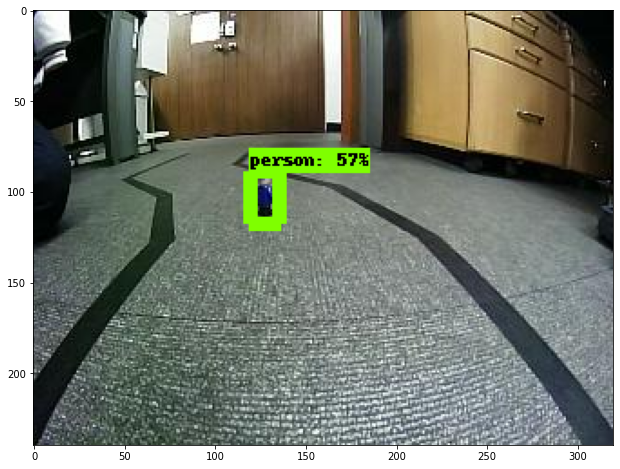

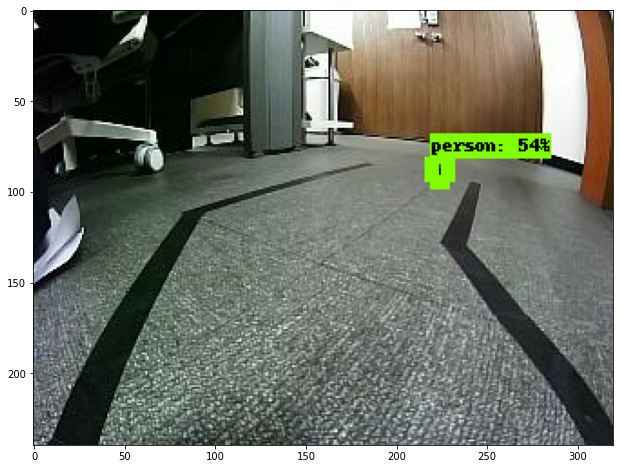

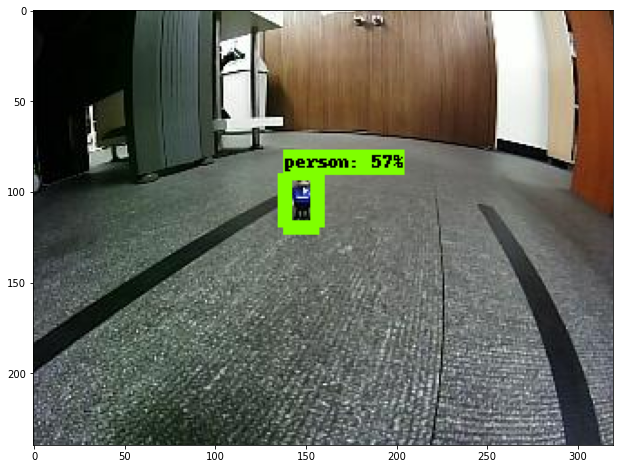

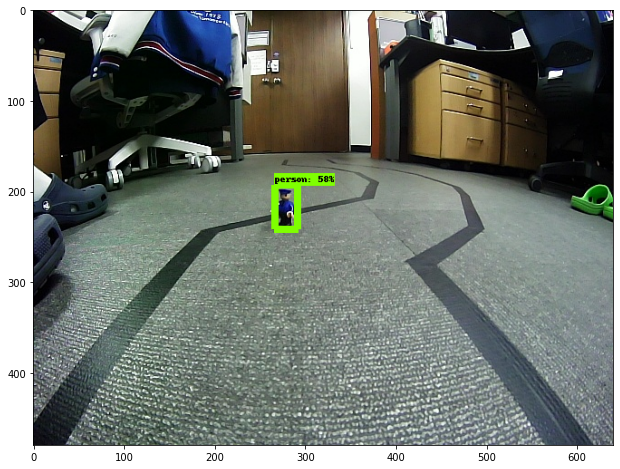

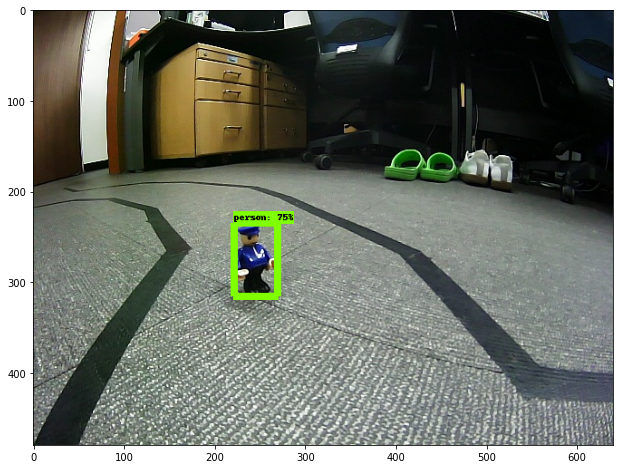

In [3]:
# Do a Quick Evaluation on the inference graph model.
import numpy as np
import os
import sys
import tensorflow as tf

from collections import defaultdict
from matplotlib import pyplot as plt
from PIL import Image

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
%matplotlib inline

# Initialize tf.Graph()
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.compat.v1.GraphDef()
  with tf.compat.v1.gfile.GFile('objects_on_road_processor/model/ssd_mobilenet_v1_ppn/frozen_inference_graph.pb', 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

# Loads labels
label_map = label_map_util.load_labelmap('data/object_detection/annotations/label_map.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=1, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Run Inference and populates results in a dict.
def run_inference(graph, image):
  with graph.as_default():
    with tf.compat.v1.Session() as sess:
      ops = tf.compat.v1.get_default_graph().get_operations()
      all_tensor_names = [output.name for op in ops for output in op.outputs]
      tensor_dict = {}
      tensor_keys = ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']
      for key in tensor_keys:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.compat.v1.get_default_graph().get_tensor_by_name(tensor_name)
      
      # Actual inference.
      image_tensor = tf.compat.v1.get_default_graph().get_tensor_by_name('image_tensor:0')
      output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
  return output_dict

test_image_path = [os.path.join('data/object_detection/test', 'frame_000011.JPEG'),
                   os.path.join('data/object_detection/test', 'frame_000024.JPEG'),
                   os.path.join('data/object_detection/test', 'frame_000033.JPEG'),
                   os.path.join('data/object_detection/test', 'frame_000163.JPEG'),
                   os.path.join('data/object_detection/test', 'frame_000203.JPEG'),
                   ]
for image_path in test_image_path:
  print('Evaluating:', image_path)
  image = Image.open(image_path)
  img_width, img_height = image.size
  image_np = np.array(image.getdata()).reshape((img_height, img_width, 3)).astype(np.uint8)
  # Run inference.
  output_dict = run_inference(detection_graph, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=(12, 8))
  plt.imshow(image_np)

## Export to TF Lite


In [ ]:
# Export this model to tflite_graph format
%cd /content/models/research

! python3 objects_on_road_processor/tensorflow/models/research/object_detection/export_tflite_ssd_graph.py \
  --pipeline_config_path=/home/chun/workspaces/tpu/DeepPiCar/objects_on_road_processor/model/ssdlite_mobiledet/pretrained_model/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/fp32/pipeline.config \
  --trained_checkpoint_prefix=objects_on_road_processor/model/ssdlite_mobiledet/train/model.ckpt-244 \
  --output_directory=objects_on_road_processor/model/ssdlite_mobiledet \
  --add_postprocessing_op=true

In [ ]:
# Convert to a tflite file (for CPU)
! tflite_convert \
  --output_file="objects_on_road_processor/model/ssdlite_mobiledet/ssdlite_mobiledet.tflite" \
  --graph_def_file="objects_on_road_processor/model/ssdlite_mobiledet/tflite_graph.pb" \
  --inference_type=QUANTIZED_UINT8 \
  --input_arrays="normalized_input_image_tensor" \
  --output_arrays="TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3" \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,320,320,3 \
  --allow_custom_ops

### Evaluate the TF Lite model


Evaluating: data/object_detection/test/frame_000011.JPEG
[[ 0.43235505  0.4388081   0.87116313  0.6582122 ]
 [ 0.58077544  0.4033163   0.8388979   0.48720607]
 [ 0.21295099  0.66789174  0.4710734   0.7517816 ]
 [-0.01613265  0.1613265   0.51947135  0.3420122 ]
 [ 0.7066101   0.6582122   0.91956115  0.76146114]
 [ 0.5323775   0.16455305  0.68079793  0.31297344]
 [ 0.06130408  0.46139383  0.5323775   0.9324672 ]
 [ 0.05807754  0.3000673   0.31619996  0.3839571 ]
 [ 0.687251    0.5323775   0.8356713   0.68079793]
 [ 0.3194265   0.79695296  0.4678469   0.9453734 ]]


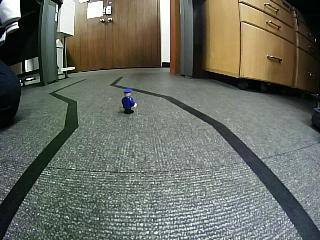

Evaluating: data/object_detection/test/frame_000024.JPEG
[[ 0.43235505  0.4388081   0.87116313  0.6582122 ]
 [ 0.58077544  0.4033163   0.8388979   0.48720607]
 [ 0.21295099  0.66789174  0.4710734   0.7517816 ]
 [-0.01613265  0.1613265   0.51947135  0.3420122 ]
 [ 0.7066101   0.6582122   0.91956115  0.76146114]
 [ 0.5323775   0.17939508  0.68079793  0.32781547]
 [ 0.06130408  0.46139383  0.5323775   0.9324672 ]
 [ 0.05807754  0.3000673   0.31619996  0.3839571 ]
 [ 0.687251    0.5323775   0.8356713   0.68079793]
 [ 0.3194265   0.79695296  0.4678469   0.9453734 ]]


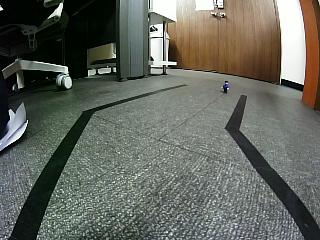

Evaluating: data/object_detection/test/frame_000033.JPEG
[[ 0.43235505  0.4388081   0.87116313  0.6582122 ]
 [ 0.58077544  0.4033163   0.8388979   0.48720607]
 [ 0.21295099  0.66789174  0.4710734   0.7517816 ]
 [-0.01613265  0.1613265   0.51947135  0.3420122 ]
 [ 0.7066101   0.6582122   0.91956115  0.76146114]
 [ 0.5323775   0.16455305  0.68079793  0.31297344]
 [ 0.06130408  0.46139383  0.5323775   0.9324672 ]
 [ 0.05807754  0.3000673   0.31619996  0.3839571 ]
 [ 0.687251    0.5472195   0.8356713   0.69563997]
 [ 0.3194265   0.79695296  0.4678469   0.9453734 ]]


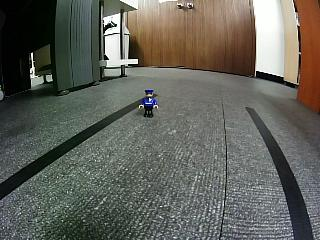

Evaluating: data/object_detection/test/frame_000163.JPEG
[[ 0.43235505  0.4388081   0.87116313  0.6582122 ]
 [ 0.58077544  0.4033163   0.8388979   0.48720607]
 [ 0.21295099  0.66789174  0.4710734   0.7517816 ]
 [-0.01613265  0.1613265   0.51947135  0.3420122 ]
 [ 0.7066101   0.6582122   0.91956115  0.76146114]
 [ 0.5323775   0.16455305  0.68079793  0.31297344]
 [ 0.06130408  0.46139383  0.5323775   0.9324672 ]
 [ 0.05807754  0.3000673   0.31619996  0.3839571 ]
 [ 0.687251    0.5323775   0.8356713   0.68079793]
 [ 0.3194265   0.79695296  0.4678469   0.9453734 ]]


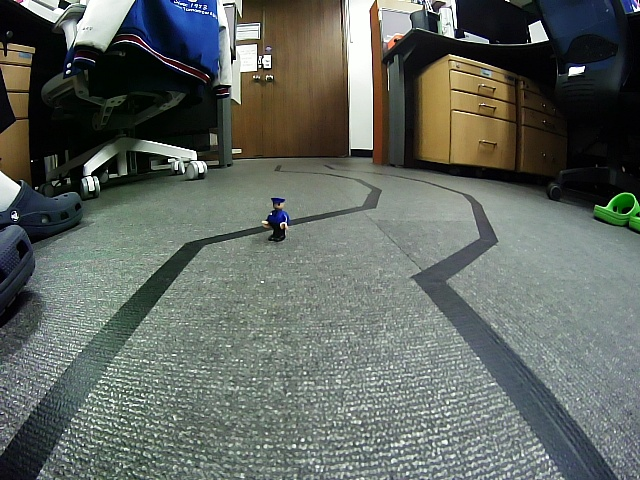

Evaluating: data/object_detection/test/frame_000203.JPEG
[[ 0.43235505  0.4388081   0.87116313  0.6582122 ]
 [ 0.58077544  0.4033163   0.8388979   0.48720607]
 [ 0.21295099  0.66789174  0.4710734   0.7517816 ]
 [-0.01613265  0.1613265   0.51947135  0.3420122 ]
 [ 0.7066101   0.6582122   0.91956115  0.76146114]
 [ 0.5323775   0.16455305  0.68079793  0.31297344]
 [ 0.06130408  0.46139383  0.5323775   0.9324672 ]
 [ 0.05807754  0.3000673   0.31619996  0.3839571 ]
 [ 0.687251    0.5323775   0.8356713   0.68079793]
 [ 0.3194265   0.79695296  0.4678469   0.9453734 ]]


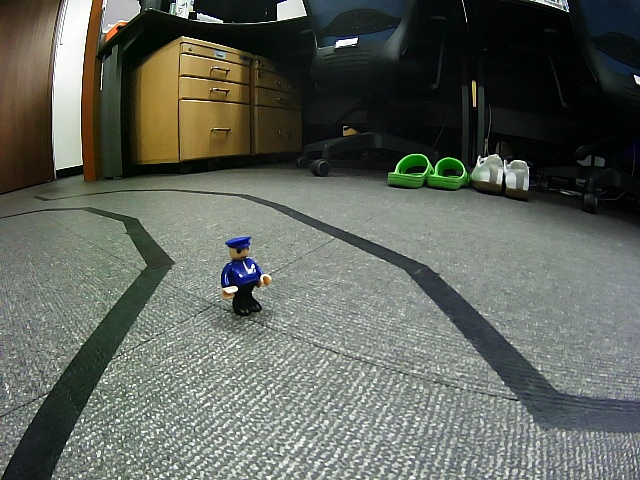

In [6]:
import os
import re
import numpy as np
from PIL import Image
from PIL import ImageDraw

from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf

# Creates tflite interpreter
interpreter = tf.lite.Interpreter("objects_on_road_processor/model/ssd_mobilenet_v1_ppn/tflite/ssd_mobilenet_v1_ppn.tflite")
interpreter.allocate_tensors()
interpreter.invoke() # warmup
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
width = input_details[0]['shape'][2]
height = input_details[0]['shape'][1]

def read_label_file(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
  ret = {}
  for row_number, content in enumerate(lines):
    pair = re.split(r'[:\s]+', content.strip(), maxsplit=1)
    if len(pair) == 2 and pair[0].strip().isdigit():
      ret[int(pair[0])] = pair[1].strip()
    else:
      ret[row_number] = content.strip()
  return ret

def run_inference(interpreter, image):
  interpreter.set_tensor(input_details[0]['index'], image)
  interpreter.invoke()
  boxes = interpreter.get_tensor(output_details[0]['index'])[0]
  classes = interpreter.get_tensor(output_details[1]['index'])[0]
  scores = interpreter.get_tensor(output_details[2]['index'])[0]
  # num_detections = interpreter.get_tensor(output_details[3]['index'])[0]
  return boxes, classes, scores

test_image_paths = [
  os.path.join('data/object_detection/test', 'frame_000011.JPEG'),
  os.path.join('data/object_detection/test', 'frame_000024.JPEG'),
  os.path.join('data/object_detection/test', 'frame_000033.JPEG'),
  os.path.join('data/object_detection/test', 'frame_000163.JPEG'),
  os.path.join('data/object_detection/test', 'frame_000203.JPEG'),
  ]
for image_path in test_image_paths:
  print('Evaluating:', image_path)
  image = Image.open(image_path)
  image_width, image_height = image.size
  draw = ImageDraw.Draw(image)
  resized_image = image.resize((width, height))
  np_image = np.asarray(resized_image)
  input_tensor = np.expand_dims(np_image, axis=0)
  # Run inference
  boxes, classes, scores = run_inference(interpreter, input_tensor)
  print(boxes)
  # Draw results on image
  colors = {0:(128, 255, 102), 1:(102, 255, 255)}
  labels = read_label_file("objects_on_road_processor/model/ssdlite_mobiledet/labels.txt")
  for i in range(len(boxes)):
    if scores[i] > .7:
      ymin = int(max(1, (boxes[i][0] * image_height)))
      xmin = int(max(1, (boxes[i][1] * image_width)))
      ymax = int(min(image_height, (boxes[i][2] * image_height)))
      xmax = int(min(image_width, (boxes[i][3] * image_width)))
      draw.rectangle((xmin, ymin, xmax, ymax), width=7, outline=colors[int(classes[i])])
      draw.rectangle((xmin, ymin, xmax, ymin-10), fill=colors[int(classes[i])])
      text = labels[int(classes[i])] + ' ' + str(scores[i]*100) + '%'
      draw.text((xmin+2, ymin-10), text, fill=(0,0,0), width=2)
  display(image)

## Compile it for the Edge TPU


Install the [Edge TPU Compiler](https://coral.ai/docs/edgetpu/compiler/):


In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
! sudo apt-get update
! sudo apt-get install edgetpu-compiler

Compile the model for the Edge TPU:


In [ ]:
%cd $OUTPUT_DIR

! edgetpu_compiler -s ssdlite_mobiledet_dog_vs_cat.tflite

## Package and download all files


In [ ]:
! cp -r /content/train/model.ckpt-$NUM_STEPS* $OUTPUT_DIR
! cp -r /content/inference_graph/* $OUTPUT_DIR

%cd /content/
! tar cvf output_ssdlite_mobiledet_dog_vs_cat.tar.gz output_ssdlite_mobiledet_dog_vs_cat

In [ ]:
from google.colab import files

files.download("/content/output_ssdlite_mobiledet_dog_vs_cat.tar.gz")


## Run it on the Edge TPU


You can now run the model on your [Coral device](https://www.coral.ai/products) with acceleration on the Edge TPU.

First, find some new photos to try. Remember that you've trained this model to recognize just two classes: Abyssinian cats and
American Bulldogs. So here are a couple images that should provide results (provided by the
[Open Images Dataset](https://storage.googleapis.com/openimages/web/index.html)):

```
wget https://c4.staticflickr.com/8/7580/15865399370_ffa5b49d20_z.jpg -O dog.jpg && \
wget https://c6.staticflickr.com/9/8534/8652503705_687d957a29_z.jpg -O cat.jpg
```

Then, try running an inference using [this example code for the PyCoral API](https://github.com/google-coral/pycoral/blob/master/examples/detect_image.py). Just clone that repo and run the script using the model files you downloaded above (also be sure you have [installed the PyCoral API](https://coral.ai/software/#pycoral-api)):

```
git clone https://github.com/google-coral/pycoral

cd pycoral/examples/

python3 detect_image.py \
  --model ssdlite_mobiledet_dog_vs_cat_edgetpu.tflite \
  --labels labels.txt \
  --input dog.jpg \
  --output dog_result.jpg
```

Check out more examples for running inference at [coral.ai/examples](https://coral.ai/examples/#code-examples/).
